# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information

Software versions
Python 3.9.13 64bit [GCC 11.2.0]
IPython 7.31.1
OS Linux 3.10.0 1127.el7.x86_64 x86_64 with glibc2.17
Wed Nov 16 15:34:04 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'pandas', 'astropy', 'ppxf', 'photutils']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.5
matplotlib: ver 3.5.2
pandas: ver 1.4.4
astropy: ver 5.1
ppxf: ver 8.2.2
photutils: ver 1.5.0


In [3]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
c = 2.99792458e+5    # light speed in km/s

from ppxf.ppxf import ppxf, robust_sigma, attenuation
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
lib.__file__

'/data01/jlee/anaconda3/lib/python3.9/site-packages/ppxf/miles_util.py'

# 1. Setting up the Stellar Libraries

In [4]:
ppxf_dir = "/data01/jlee/Downloads/E-MILES/tmp1/"
ppxf_dir2 = "/data01/jlee/Downloads/E-MILES/tmp2/"
print(ppxf_dir, ppxf_dir2)

/data01/jlee/Downloads/E-MILES/tmp1/ /data01/jlee/Downloads/E-MILES/tmp2/


In [5]:
pathname = ppxf_dir + 'Ech1.30*.fits'
pathname

'/data01/jlee/Downloads/E-MILES/tmp1/Ech1.30*.fits'

In [6]:
# sorted(glob.glob(pathname))

In [7]:
pathname2 = ppxf_dir2 + 'Ech1.30*.fits'
pathname2

'/data01/jlee/Downloads/E-MILES/tmp2/Ech1.30*.fits'

# 2. Loading the Spectra

In [8]:
# ----- Loading MUSE spectra data cube ----- #
dir_cube = "./"
filename = dir_cube + "NGC0628_PHANGS_DATACUBE_copt_0.92asec.fits"
sp = fits.open(filename)

In [9]:
sp.info()

Filename: ./NGC0628_PHANGS_DATACUBE_copt_0.92asec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   ()      
  1  DATA          1 ImageHDU        48   (1412, 1426, 3761)   float32   
  2  STAT          1 ImageHDU        49   (1412, 1426, 3761)   float32   
  3  DQ            1 ImageHDU        48   (1412, 1426, 3761)   uint8   


In [10]:
d_sci, h_sci = sp[1].data, sp[1].header
d_var, h_var = sp[2].data, sp[2].header
wav_obs = np.linspace(start=h_sci['CRVAL3']+(1-h_sci['CRPIX3'])*h_sci['CD3_3'],
                      stop=h_sci['CRVAL3']+(h_sci['NAXIS3']-h_sci['CRPIX3'])*h_sci['CD3_3'],
                      num=h_sci['NAXIS3'], endpoint=True)
wav_obs

array([4700.  , 4701.25, 4702.5 , ..., 9397.5 , 9398.75, 9400.  ])

In [11]:
d_sci.shape, d_var.shape

((3761, 1426, 1412), (3761, 1426, 1412))

In [12]:
# from photutils.aperture import CircularAperture as CAp
# rad = 25    # 5 arcsec
xInd, yInd = 707-1, 757-1    # Center coordinates (X, Y)
# ap = CAp((xInd, yInd), r=rad)
# ap_msk = ap.to_mask(method='exact')
# msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
# print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

# circular_spectrum = np.nansum(d_sci*msk, axis=(1, 2))
# circular_variance = np.nansum(d_var*msk, axis=(1, 2))
# print(circular_spectrum.shape)

pxs_SPHEREx = 6.2    # arcsec/pixel
pxs_MUSE = 0.2    # arcsec/pixel
rth = int(pxs_SPHEREx/pxs_MUSE/2)

box_spectrum = np.nansum(d_sci[:, yInd-rth:yInd+rth+1, xInd-rth:xInd+rth+1], axis=(1,2))
box_variance = np.nansum(d_var[:, yInd-rth:yInd+rth+1, xInd-rth:xInd+rth+1], axis=(1,2))
print(box_spectrum.shape)

(3761,)


## Plotting the object spectra

<IPython.core.display.Javascript object>


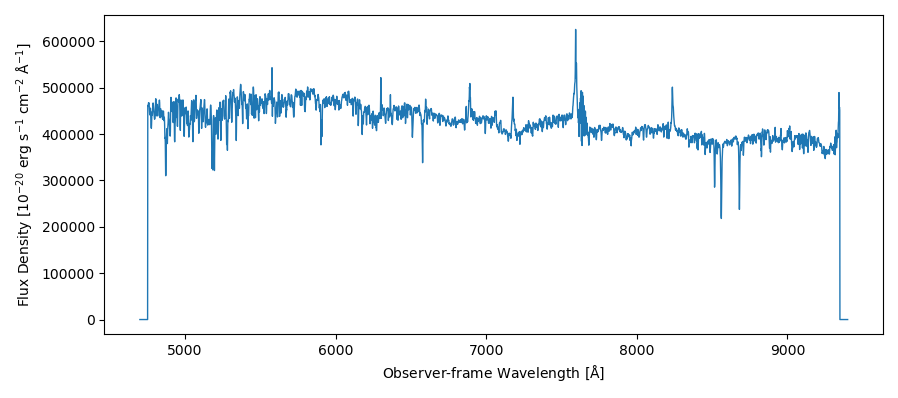

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, box_spectrum, '-', linewidth=1.0)
ax.set_xlabel(r"Observer-frame Wavelength [$\rm \AA$]")
ax.set_ylabel(r"Flux Density [$10^{-20}~{\rm erg~s^{-1}~cm^{-2}~\AA^{-1}}$]")
plt.tight_layout()
plt.savefig("Spectra0.png", dpi=300)

## Plotting the S/N

In [14]:
box_variance[box_variance == 0] = np.median(box_variance)

<IPython.core.display.Javascript object>


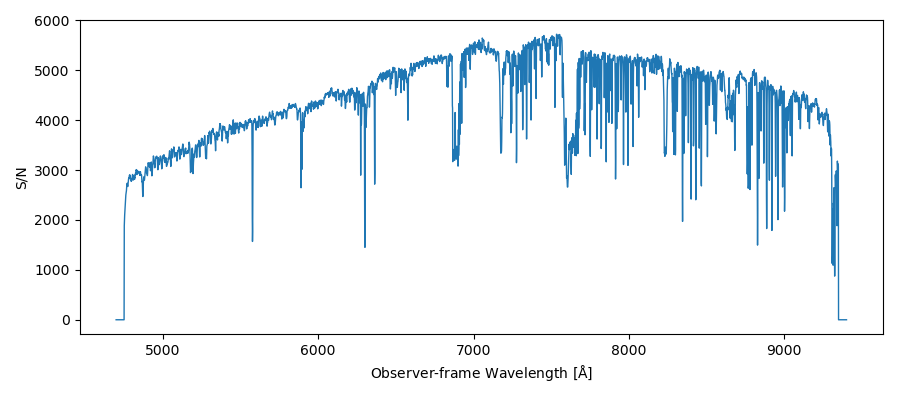

In [15]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, box_spectrum/np.sqrt(box_variance), '-', linewidth=1.0)
ax.set_xlabel(r"Observer-frame Wavelength [$\rm \AA$]")
ax.set_ylabel(r"S/N")
plt.tight_layout()
plt.savefig("Spectra1.png", dpi=300)

# 3. Basic Settings for pPXF

In [16]:
eff = ((wav_obs >= 4800.) & (wav_obs <= 9000.))
lam = wav_obs[eff]
galaxy = box_spectrum[eff] / np.median(box_spectrum[eff])
noise = np.ones_like(galaxy)
# noise = np.sqrt(box_variance[eff] / np.median(box_spectrum[eff])**2.)
# regul_err = np.median(noise)
# regul_err

## Re-binning of the Spectra with the log scale

In [17]:
# velscale = c * np.diff(np.log(lam[[0, -1]]) / (lam.size-1))    # works for both log- and linear- scales
velscale = c * np.diff(np.log(lam[-2:]))    # only works for the log- scale  (Smallest velocity step)
# print(velscale)
velscale = velscale[0]
print(f"Velocity scale per pixel: {velscale:.2f} km/s")

galaxy2, ln_lam_gal, velscale = util.log_rebin([4800., 9000.], galaxy, velscale=velscale)
noise2 = np.ones_like(galaxy2)
lam2 = np.exp(ln_lam_gal)

Velocity scale per pixel: 41.64 km/s


## Masking the Spectra

In [18]:
msk_flag = np.zeros_like(galaxy)
msk_region = [[5570., 5590.],
              [5882., 5895.],
              [6280., 6320.],
              [6350., 6380.],
              [6850., 6925.],
              [7000., 8490.],
              [8700., 9000.]]
for m in msk_region:
    idmsk_l = np.argmin(np.abs(m[0]-lam))
    idmsk_r = np.argmin(np.abs(m[1]-lam))+1
    msk_flag[idmsk_l:idmsk_r] = 1
goodpixels0 = np.flatnonzero(msk_flag == 0)
assert msk_flag[goodpixels0].sum() == 0.0

In [19]:
msk_flag2 = np.zeros_like(galaxy2)
for m in msk_region:
    idmsk_l = np.argmin(np.abs(m[0]-lam2))
    idmsk_r = np.argmin(np.abs(m[1]-lam2))+1
    msk_flag2[idmsk_l:idmsk_r] = 1
goodpixels2 = np.flatnonzero(msk_flag2 == 0)
assert msk_flag2[goodpixels2].sum() == 0.0

<IPython.core.display.Javascript object>


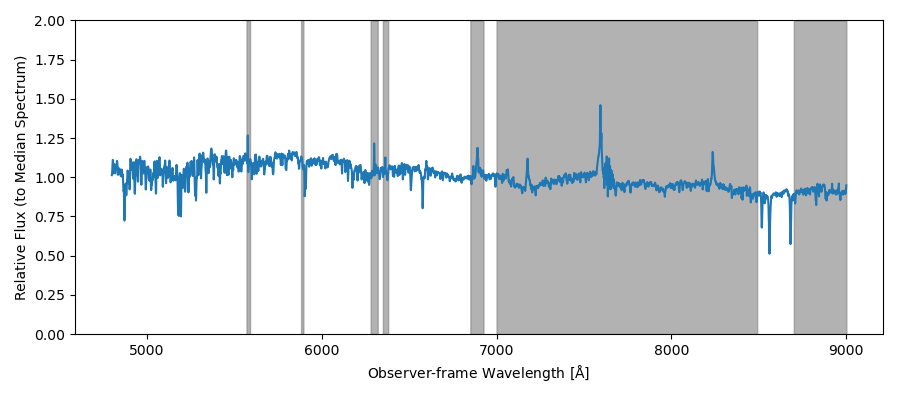

In [20]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(lam2, galaxy2)
for m in msk_region:
    ax.fill_betweenx(2.*np.arange(1000)/1000, m[0], m[1], color='gray', alpha=0.6)
ax.set_xlabel(r"Observer-frame Wavelength [$\rm \AA$]")
ax.set_ylabel("Relative Flux (to Median Spectrum)")
ax.set_ylim([0., 2.])
plt.tight_layout()
plt.savefig("Spectra2.png", dpi=300)

## Making the Stellar Templates

In [21]:
FWHM_gal = 2.62    # Median FWHM resolution of MUSE
# FWHM_gal = None
miles = lib.miles(pathname, velscale, FWHM_gal,
                  age_range=[0.15, 14], metal_range=[-1.5, 0.4],
                  norm_range=[5070, 5950])#, wave_range=[4800., 7050.])
reg_dim = miles.templates.shape[1:]
print(reg_dim)
# miles.templates.shape
# miles.age_grid.shape
# miles.age_grid
# miles.metal_grid
# miles.ln_lam_temp
# miles.lam_temp

(10, 4)


In [22]:
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
stars_templates.shape

(24430, 40)

# 4. Initial Running pPXF for Stellar Components

In [23]:
# start = [100., 180.]
# pp = ppxf(stars_templates, galaxy, noise,
#           velscale, start, goodpixels=goodpixels0,
#           moments=4, degree=4, mdegree=0,
#           lam=lam, lam_temp=miles.lam_temp)

# plt.figure(figsize=(9,4))
# pp.plot()
# plt.savefig("pPXF_results0.png", dpi=300)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       658        47    -0.024     0.063
chi2/DOF: 9.671e-05; DOF: 2684; degree = 4; mdegree = 0
method = capfit; Jac calls: 12; Func calls: 65; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/40


<IPython.core.display.Javascript object>


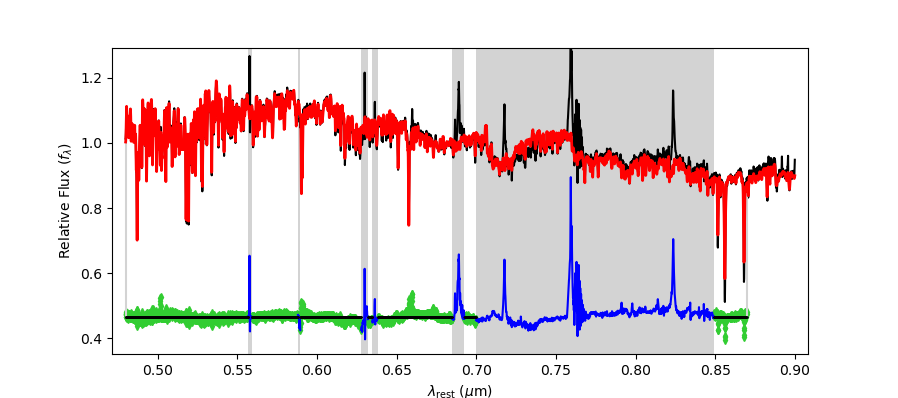

In [24]:
start = [100., 180., 0.1, 0.1]
pp = ppxf(stars_templates, galaxy2, noise2,
          velscale, start, goodpixels=goodpixels2,
          moments=4, degree=4, mdegree=0,
          lam=lam2, lam_temp=miles.lam_temp)#,
          #reddening=0.1)

plt.figure(figsize=(9,4))
pp.plot()
plt.savefig("pPXF_results1.png", dpi=300)

# 5. Iterative Running pPXF for Stellar Components (for stellar kinematics)

In [25]:
def clip_outliers(galaxy, bestfit, goodpixels, sigma=3):
    """
    Repeat the fit after clipping bins deviants more than n*sigma
    in relative error until the bad bins don't change any more.
    """
    print(len(goodpixels), "/", len(galaxy))
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < sigma*err)
        print(len(goodpixels), "/", len(galaxy))
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

In [26]:
goodpixels3 = clip_outliers(galaxy2, pp.bestfit, goodpixels2, sigma=5)

2688 / 4527
4356 / 4527
4409 / 4527
4412 / 4527
4412 / 4527


In [27]:
goodpixels3 = np.intersect1d(goodpixels3, goodpixels2)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       659        49    -0.032     0.052
chi2/DOF: 8.511e-05; DOF: 2677; degree = 4; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 52; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/40


<IPython.core.display.Javascript object>


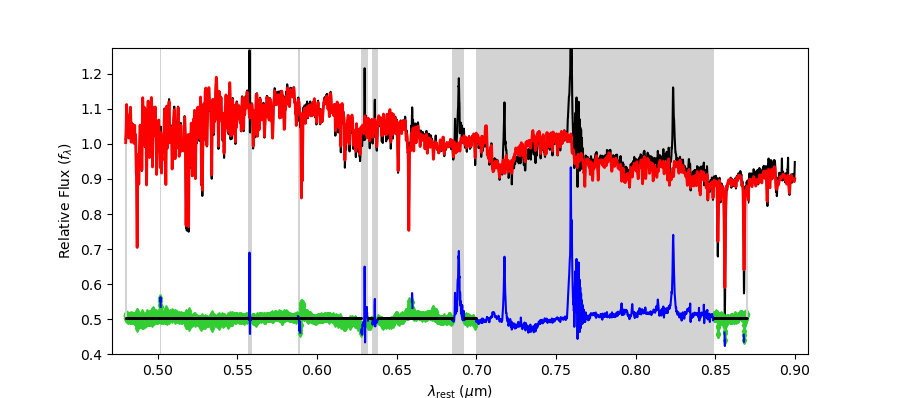

In [28]:
start = [100., 180., 0.1, 0.1]
pp = ppxf(stars_templates, galaxy2, noise2,
          velscale, start, goodpixels=goodpixels3,
          moments=4, degree=4, mdegree=0,
          lam=lam2, lam_temp=miles.lam_temp)#,
          #reddening=0.1)

plt.figure(figsize=(9,4))
pp.plot()
plt.savefig("pPXF_results2.png", dpi=300)

In [29]:
vel, sigma, h3, h4 = pp.sol
print(vel, sigma, h3, h4)

658.5611181348798 49.41361932927519 -0.03249860361941175 0.051873906231554745


# 6. Adding More Templates

In [30]:
miles2 = lib.miles(pathname2, velscale, FWHM_gal, norm_range=[5070, 5950])
reg_dim2 = miles2.templates.shape[1:]
print(reg_dim2)

stars_templates2 = miles2.templates.reshape(miles.templates.shape[0], -1)
stars_templates2 /= np.median(stars_templates2) # Normalizes stellar templates by a scalar
print(stars_templates2.shape)

(13, 6)
(24430, 78)


## Deriving the Stellar Absorption (with fixed stellar kinematics)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       659        49    -0.030     0.097
Stars Attenuation A_V: 0.236
chi2/DOF: 0.0001650; DOF: 2678; degree = -1; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/78


<IPython.core.display.Javascript object>


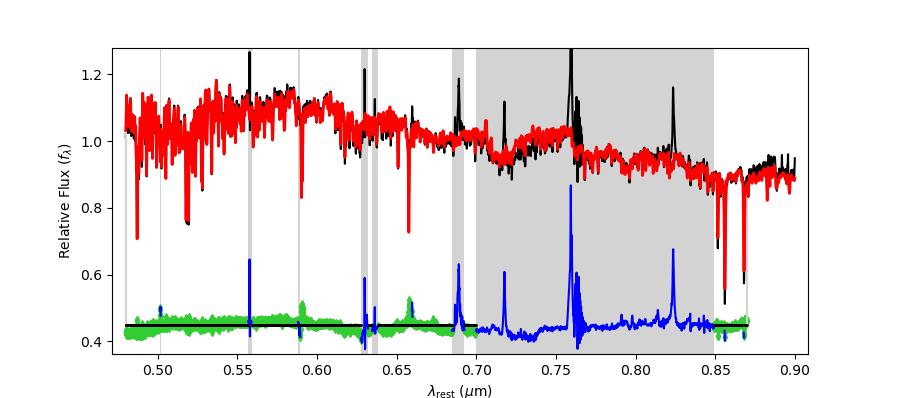

In [31]:
start = [vel, sigma, h3, h4]
fixed = [1, 1, 0, 0]
a_v0 = 0.1
pp = ppxf(stars_templates2, galaxy2, noise2,
          velscale, start, goodpixels=goodpixels3,
          moments=4, degree=-1, mdegree=-1,
          lam=lam2, lam_temp=miles.lam_temp, fixed=fixed,
          reddening=a_v0)

plt.figure(figsize=(9,4))
pp.plot()
plt.savefig("pPXF_results3.png", dpi=300)

In [32]:
a_v_star = pp.reddening
print(a_v_star)

0.23588900883264527


# 7. Deriving the Stellar Population Parameters

In [33]:
f_extn = attenuation(lam2, a_v_star)
f_extn

array([0.77897502, 0.77900162, 0.77902821, ..., 0.88935846, 0.88937883,
       0.88939919])

In [34]:
galaxy3 = galaxy2 / f_extn
galaxy3 /= np.median(galaxy3)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       659        49    -0.032     0.052
chi2/DOF: 0.0001703; DOF: 2681; degree = -1; mdegree = 0
method = linear; Jac calls: 0; Func calls: 1; Status: 1
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/78


<IPython.core.display.Javascript object>


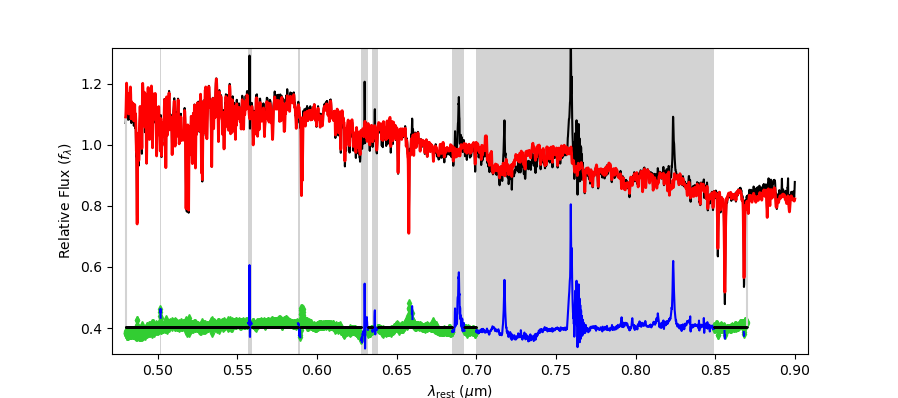

In [35]:
start = [vel, sigma, h3, h4]
fixed = [1, 1, 1, 1]
pp = ppxf(stars_templates2, galaxy3, noise2,
          velscale, start, goodpixels=goodpixels3,
          moments=4, degree=-1, mdegree=-1,
          lam=lam2, lam_temp=miles.lam_temp, fixed=fixed)

plt.figure(figsize=(9,4))
pp.plot()
plt.savefig("pPXF_results4.png", dpi=300)

In [36]:
light_weights = pp.weights#[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim2)  # Reshape to (n_ages, n_metal)
light_weights /= light_weights.sum()            # Normalize to light fractions
# print(light_weights)
# Given that the templates are normalized to the V-band, the pPXF weights
# represent v-band light fractions and the computed ages and metallicities
# below are also light weighted in the V-band.
print("\n--- Luminosity-weighted values ---")
logAge_lw, Z_lw = miles2.mean_age_metal(light_weights)
print(logAge_lw, Z_lw)
# For the M/L one needs to input fractional masses, not light fractions.
# For this, I convert light-fractions into mass-fractions using miles.flux
mass_weights = light_weights/miles2.flux
mass_weights /= mass_weights.sum()              # Normalize to mass fractions
# print(mass_weights)
print("\n--- Mass-weighted values ---")
logAge_mw, Z_mw = miles2.mean_age_metal(mass_weights)
print(logAge_mw, Z_mw)


--- Luminosity-weighted values ---
Weighted <lg_age> [yr]: 9.59
Weighted <[M/H]>: -0.143
9.593108221551994 -0.14265040901950116

--- Mass-weighted values ---
Weighted <lg_age> [yr]: 9.83
Weighted <[M/H]>: -0.169
9.831849707769496 -0.16940453641278042


In [37]:
# ml = mass_weights / light_weights
# np.nansum(ml)

# ML_r = miles.mass_to_light(mass_weights, band="r")
# print(ML_r)
# Mstar = ML_r * 2.5 ** (r0-(fiber_mag_r-dist_mod))
# print(f"log M*/Mo = {np.log10(Mstar):.3f}")

In [38]:
def mass_to_light(temp, weights, magfile, band="r", quiet=False):

#     vega_bands = ["U", "B", "V", "R", "I", "J", "H", "K"]
    sdss_bands = ["u", "g", "r", "i", "z"]
#     vega_sun_mag = [5.600, 5.441, 4.820, 4.459, 4.148, 3.711, 3.392, 3.334]
    sdss_sun_mag = [6.45, 5.14, 4.65, 4.54, 4.52]  # values provided by not Elena Ricciardelli, but http://mips.as.arizona.edu/~cnaw/sun_2006.html
    
    i = sdss_bands.index(band)
    sun_mag = sdss_sun_mag[i]
    
    dt = pd.read_csv(magfile, sep=' ')
    
    mass_grid = np.empty_like(weights)
    lum_grid  = np.empty_like(weights)
    for j in range(temp.n_ages):
        for k in range(temp.n_metal):
            p1 = ((np.abs(temp.age_grid[j, k] - dt['Age']) < 0.001) & \
                  (np.abs(temp.metal_grid[j, k] - dt['Z']) < 0.01))
            mass_grid[j, k] = dt['M(*+remn)'][p1]
            lum_grid[j, k] = 10**(-0.4*(dt[band+'_SDSS'][p1] - sun_mag))
                     
    # This is eq.(2) in Cappellari+13
    # http://adsabs.harvard.edu/abs/2013MNRAS.432.1862C
    mlpop = np.sum(weights*mass_grid)/np.sum(weights*lum_grid)

    if not quiet:
        print(f'(M*/L)_{band}: {mlpop:#.4g}')

    return [mass_grid, lum_grid, mlpop]

In [39]:
magfile = "/data01/jlee/Downloads/E-MILES/sdss_ch_iTp0.00.MAG"
mg, lg, ml = mass_to_light(miles2, mass_weights, magfile, band="r")

(M*/L)_r: 1.713


In [40]:
bestemp = stars_templates2 @ pp.weights

2.908627515507894


<IPython.core.display.Javascript object>


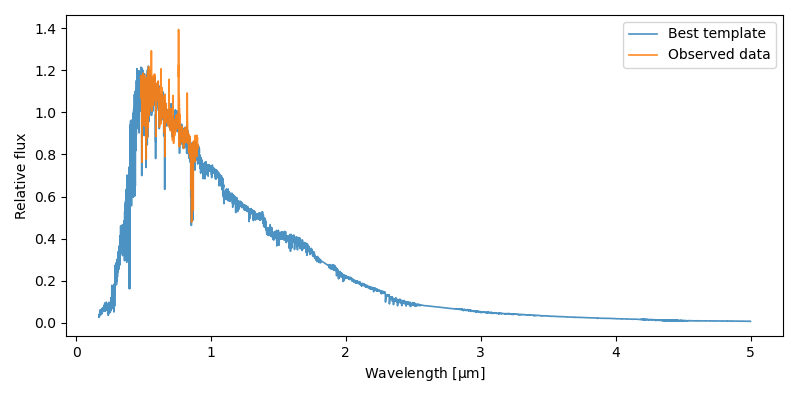

In [41]:
mfac = np.trapz(bestemp[(miles2.lam_temp >= np.min(lam2)) & (miles2.lam_temp <= np.max(lam2))],
                x=miles2.lam_temp[(miles2.lam_temp >= np.min(lam2)) & (miles2.lam_temp <= np.max(lam2))]) / \
       np.trapz(pp.bestfit, x=lam2)
print(mfac)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(miles2.lam_temp*1.0e-4, bestemp / mfac, lw=1.2, alpha=0.8, label="Best template")
ax.plot(lam2*1.0e-4, galaxy3, lw=1.2, alpha=0.9, label="Observed data")
# ax.plot(lam2*1.0e-4, pp.bestfit, lw=1.2, alpha=0.9, label="Best-fit model")
ax.set_xlabel(r"Wavelength [${\rm \mu m}$]")
ax.set_ylabel("Relative flux")
ax.legend()
plt.tight_layout()
plt.savefig("pPXF_best.png", dpi=300)

# 8. Adding the Gas Components

In [42]:
# lam_range_gal = np.array([np.min(lam2), np.max(lam2)])# / (1+redshift)    # rest-frame wavelength
# print(lam_range_gal)
# gas_templates, gas_names, line_wave = util.emission_lines(
#     miles.ln_lam_temp, lam_range_gal, FWHM_gal)

In [43]:
# gas_templates = gas_templates[:, :2]
# gas_names = gas_names[:2]
# gas_names

In [44]:
# templates = np.column_stack([stars_templates2, gas_templates])
# templates.shape

In [45]:
# n_temps = stars_templates2.shape[1]
# n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
# n_balmer = len(gas_names) - n_forbidden
# print(n_temps, n_forbidden, n_balmer)

# # Assign component=0 to the stellar templates, component=1 to the Balmer
# # gas emission lines templates and component=2 to the forbidden lines.
# comp_emit = np.ones(n_balmer + n_forbidden).astype('int')
# comp_emit[np.array(["[" in a for a in gas_names])] = 2
# component = [0]*n_temps + list(comp_emit)
# gas_component = np.array(component) > 0  # gas_component=True for gas templates
# print(component)

# # Fit (V, sig, h3, h4) moments=4 for the stars
# # and (V, sig) moments=2 for the two gas kinematic components
# moments = [-4, 2]

# # Adopt the same starting value for the stars and the two gas components
# start = [[vel, sigma, h3, h4], [vel, 180.]]
# print(start)

# # If the Balmer lines are tied one should allow for gas reddeining.
# # The gas_reddening can be different from the stellar one, if both are fitted.
# gas_reddening = 0

## pPXF Fitting for Both Stellar and Gas Components

In [46]:
# pp = ppxf(templates, galaxy2, noise2,
#           velscale, start, goodpixels=goodpixels3,
#           moments=moments, degree=-1, mdegree=12,
#           lam=lam2, lam_temp=miles.lam_temp,
#           reg_dim=reg_dim, #regul=1/regul_err,
#           component=component, gas_component=gas_component,
#           reddening=ebv_star, gas_reddening=0.1, gas_names=gas_names)

# plt.figure(figsize=(9,4))
# pp.plot()
# plt.savefig("pPXF_results5.png", dpi=300)